C:\Users\ky090\OneDrive - The University of Texas at Austin\001_Market\005_Python
C:\Users\ky090\OneDrive - The University of Texas at Austin\001_Market\100_Output
Currency Return as of 20230707 (BGN, vsUSD)


,Currency,1D,vs06/30,vs03/31,Carry
0,JPY,1.3%,1.5%,-6.6%,-6.0%
1,NOK,1.3%,1.1%,-1.5%,-1.4%
2,SEK,1.1%,-0.2%,-3.9%,-1.7%
3,AUD,1.0%,0.4%,0.1%,-1.2%
4,NZD,0.9%,1.4%,-0.8%,0.2%
5,GBP,0.8%,1.1%,4.1%,-0.2%
6,CHF,0.7%,0.8%,3.0%,-3.7%
7,CAD,0.7%,-0.2%,1.8%,-0.5%
8,EUR,0.7%,0.5%,1.2%,-1.8%
9,CNY,0.3%,0.4%,-4.9%,-3.1%


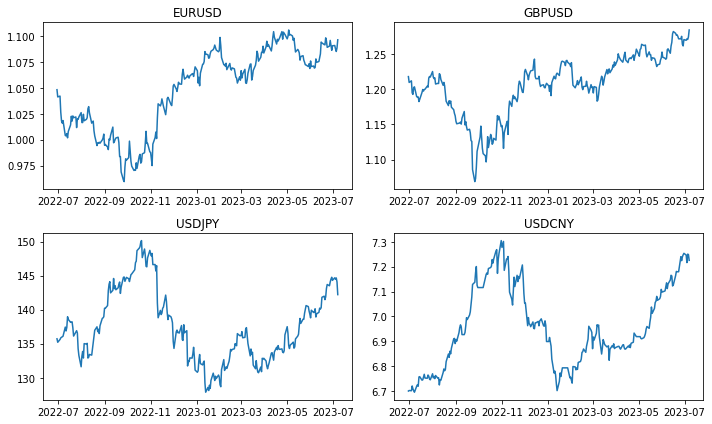

In [1]:
import os
path = r"C:/Users/ky090/OneDrive - The University of Texas at Austin/001_Market/005_Python"
path = path.replace("\\", "/")
os.chdir(path)
print(os.getcwd())
# https://smart-hint.com/python/style/
# https://www.salesanalytics.co.jp/datascience/datascience046/

%matplotlib inline
%run -m FX_Rank

## The following code is the same code as in FX_Rank.py

In [2]:
import pdblp
from xbbg import blp
import workdays
import time
import datetime
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
import calendar
import base64
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 70)

In [3]:
ODA = workdays.workday(date.today(), days=-1).strftime("%Y%m%d") #One day agp
TDA= workdays.workday(date.today(), days=-2)  #Two days ago
OYA = TDA - relativedelta(months=13)
OYA = OYA.replace(day=calendar.monthrange(OYA.year, OYA.month)[1]) #One year ago

if TDA.month > 3 or (TDA.month == 3 and TDA.day == 31):
    YE = date(TDA.year, 3, 31).strftime("%Y%m%d")
else:
    YE = date(TDA.year - 1, 3, 31).strftime("%Y%m%d")
    
L = ["EUR","JPY","GBP","CNY","NZD","NOK","AUD","CAD","CHF","SEK"]
T = [i + "USD BGN Curncy" for i in L] 
df = blp.bdh(T, "px_last", YE, ODA, Days="W", Fill="P").reset_index()
df = df[["index"]+T]
df.columns = ["Date"] + L
df

,Date,EUR,JPY,GBP,CNY,NZD,NOK,AUD,CAD,CHF,SEK
0,2023-03-31,1.0839,0.007527,1.2337,0.14548,0.6258,0.0955,0.6685,0.7398,1.0926,0.096114
1,2023-04-03,1.0899,0.007549,1.2414,0.14540,0.6297,0.0971,0.6786,0.7442,1.0959,0.096403
2,2023-04-04,1.0953,0.007592,1.2501,0.14536,0.6313,0.0970,0.6751,0.7438,1.1037,0.097301
3,2023-04-05,1.0904,0.007615,1.2462,0.14536,0.6318,0.0958,0.6720,0.7431,1.1028,0.096124
4,2023-04-06,1.0922,0.007588,1.2440,0.14550,0.6243,0.0957,0.6672,0.7411,1.1056,0.095894
...,...,...,...,...,...,...,...,...,...,...,...
66,2023-07-03,1.0912,0.006912,1.2693,0.13799,0.6153,0.0935,0.6673,0.7547,1.1158,0.092184
67,2023-07-04,1.0879,0.006922,1.2713,0.13858,0.6191,0.0938,0.6692,0.7562,1.1148,0.092331
68,2023-07-05,1.0854,0.006913,1.2704,0.13792,0.6179,0.0937,0.6655,0.7529,1.1126,0.091444
69,2023-07-06,1.0889,0.006941,1.2740,0.13795,0.6157,0.0929,0.6626,0.7480,1.1170,0.091425


In [4]:
L2 = ["EURUSD","USDJPY","GBPUSD","USDCNY"]
T2 = [i + " BGN Curncy" for i in L2]
df2 = blp.bdh(T2, "px_last", OYA, ODA, Days="W", Fill="P").reset_index()
df2 = df2[["index"]+T2]
df2.columns = ["Date"] + L2
df2

,Date,EURUSD,USDJPY,GBPUSD,USDCNY
0,2022-06-30,1.0484,135.72,1.2178,6.6993
1,2022-07-01,1.0414,135.21,1.2095,6.7015
2,2022-07-04,1.0422,135.62,1.2118,6.7006
3,2022-07-05,1.0266,135.85,1.1947,6.7197
4,2022-07-06,1.0182,135.95,1.1926,6.7080
...,...,...,...,...,...
262,2023-07-03,1.0912,144.68,1.2693,7.2468
263,2023-07-04,1.0879,144.47,1.2713,7.2163
264,2023-07-05,1.0854,144.66,1.2704,7.2505
265,2023-07-06,1.0889,144.07,1.2740,7.2488


In [5]:
T0 = [i + " BGN Curncy" for i in L]
T1 = [i + "1M BGN Curncy" for i in L]
T1 = [x.replace("CNY", "CNH") for x in T1]

BDP0 = blp.bdp(tickers=T0, flds=["px_last","fwd_scale","is_pct_chg_app_base_crncy"]).loc[T0,:]
BDP1 = blp.bdp(tickers=T1, flds=["px_last"]).loc[T1,:]

BDP = BDP0.reset_index(drop=True)
BDP.insert(0, "Curncy", L)
BDP.insert(2, "frd_point", BDP1["px_last"].tolist())
BDP.insert(3, "Carry", 0)
BDP["Carry"] = (1 + BDP["frd_point"] / BDP["px_last"] / 10 ** BDP["fwd_scale"] ) ** 12 - 1

BDP

,Curncy,px_last,frd_point,Carry,fwd_scale,is_pct_chg_app_base_crncy
0,EUR,1.0967,16.76,0.0184936,4,N
1,JPY,142.21,-73.21,-0.0600568,2,Y
2,GBP,1.2839,2.42,0.0022642,4,N
3,CNY,7.2254,-191.25,-0.0313046,4,Y
4,NZD,0.621,-0.81,-0.0015641,4,N
5,NOK,10.6219,-125.08,-0.0140396,4,Y
6,AUD,0.669,6.61,0.0119211,4,N
7,CAD,1.3274,-5.68,-0.00512278,4,Y
8,CHF,0.8887,-28.20,-0.0374205,4,Y
9,SEK,10.8231,-157.00,-0.017269,4,Y


C:\Users\ky090\OneDrive - The University of Texas at Austin\001_Market\100_Output
Currency Return as of 20230707 (BGN, vsUSD)


,Currency,1D,vs06/30,vs03/31,Carry
0,JPY,1.3%,1.5%,-6.6%,-6.0%
1,NOK,1.3%,1.1%,-1.5%,-1.4%
2,SEK,1.1%,-0.2%,-3.9%,-1.7%
3,AUD,1.0%,0.4%,0.1%,-1.2%
4,NZD,0.9%,1.4%,-0.8%,0.2%
5,GBP,0.8%,1.1%,4.1%,-0.2%
6,CHF,0.7%,0.8%,3.0%,-3.7%
7,CAD,0.7%,-0.2%,1.8%,-0.5%
8,EUR,0.7%,0.5%,1.2%,-1.8%
9,CNY,0.3%,0.4%,-4.9%,-3.1%


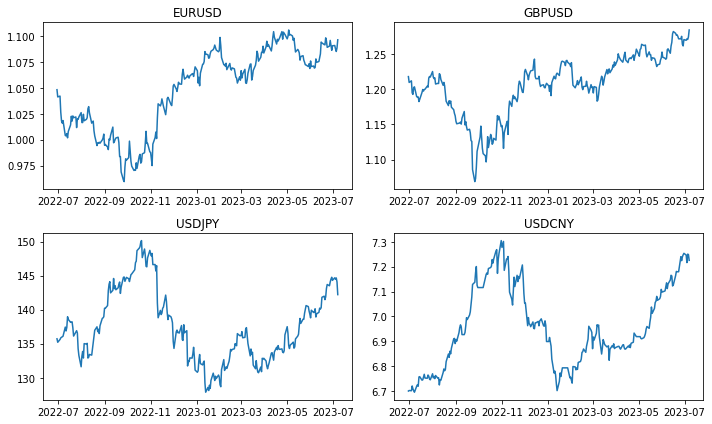

In [6]:
TDA= workdays.workday(date.today(), days=-2) #Two days ago
ME = (date(TDA.year, TDA.month, 1) + relativedelta(months=-1, day=31)).strftime("%Y/%m/%d") #Month End
YE = date(TDA.year, 3, 31) if TDA.month > 3 or (TDA.month == 3 and TDA.day == 31) else date(TDA.year - 1, 3, 31) #Year End
YE = YE.strftime("%Y/%m/%d")
TDA = TDA.strftime("%Y/%m/%d")  

C = ["TDA","ME","YE"]
FX = pd.DataFrame(L, columns=["Curncy"])

tmp = df.loc[len(df)-1, L]

for i in C:
    exec(f"d = {i}")
    FX[i] = (tmp / df.loc[df["Date"]==d, L] - 1).values[0]


FX["Carry"] = np.where(BDP["is_pct_chg_app_base_crncy"] == "Y", BDP["Carry"], -BDP["Carry"])
FX.sort_values(by="TDA", ascending=False, inplace=True)
FX = FX.reset_index(drop=True)

C = ["Currency","1D","vs"+ME[5:],"vs"+YE[5:],"Carry"]
FX.columns= C


html = FX.style\
    .bar(subset=C[1:], align='mid', color=["pink", "lightblue"])\
    .format({c: '{:.1%}' for c in C[1:]})\
    .render()

fig, ax = plt.subplots(2,2,figsize=(10,6),tight_layout=True)
for i in range(len(L2)):
    ax[i%2,i//2].plot(df2["Date"], df2[L2[i]])
    ax[i%2,i//2].set_title(L2[i])
plt.savefig("tmp.png")

with open("tmp.png", "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()
html += f'<img src="data:image/png;base64,{encoded_string}">'

path = r"C:\Users\ky090\OneDrive - The University of Texas at Austin\001_Market\100_Output"
path = path.replace("\\", "/")
os.chdir(path)
print(os.getcwd())
with open("FX_" + datetime.now().strftime('%Y%m%d') + ".html", "w") as f:
    f.write(html)
    

print("Currency Return as of "+ODA+" (BGN, vsUSD)")
display(FX.style\
        .bar(subset=C[1:], align='mid', color=["pink", "lightblue"])\
        .format({c: '{:.1%}' for c in C[1:]})\
       )

plt.show()